# Processing Pipeline for the Data as provided from WBD

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ka_walsum_rueb_21_folder = "ka_vierlinden_2021"
ka_walsum_rueb_22_23_folder = "ka_vierlinden_2022_2023"
pumpbauwerk_folder = "pump_sonderbauwerke_vierlinden"
niederschlag_folder = "niederschlag_vierlinden_baerl"

pumpbauwerk_filename = 'pumpbauwerk_vierlinden.csv'
rainfall_filename = 'niederschlag_vierlinden.csv'
regenbecken_filename = 'regenbecken_vierlinden.csv'
final_data_filename = 'vierlinden_21_22_23_all.csv'

def process_pumpbauwerk_csv_file(filepath, sep = ';', decimal = ',', encoding = 'latin1'):
    
    # Read file into DataFrame
    df = pd.read_csv(filepath, sep=sep, decimal=decimal, encoding=encoding)
    
    # Prepare datetime column
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'] + '.' + df['Millisecond'].astype(str), format='%d.%m.%Y %H:%M:%S.%f')
    df.drop(columns=['Date', 'Time', 'Millisecond'], inplace=True)
    df.set_index('datetime', inplace=True)

    # Round datetime to full hour for grouping
    df.insert(0, 'rounded_hour', pd.to_datetime(df.index.round('H')))

    # Caluculate weights according to the distance to closest full hour
    df['seconds_to_nearest_hour'] = df.index.minute * 60 + df.index.second
    df['seconds_to_nearest_hour'] = df['seconds_to_nearest_hour'].apply(lambda x: min(x, 3600 - x))
    df['weight'] = 1 - (df['seconds_to_nearest_hour'] / 3600)

    # Initialize a dictionary to store weighted mean results per rounded_hour for each column
    weighted_means = {}

    # List of columns to calculate weighted means for, excluding 'rounded_hour' and other non-data columns
    data_columns = df.columns.difference(['rounded_hour', 'seconds_to_nearest_hour', 'weight'], sort = False)

    # Calculate weighted mean for each column, grouped by 'rounded_hour'
    for column in data_columns:
        # Filter out NaN values from the column before calculating weighted sums and sum of weights
        valid_data = df[df[column].notna()]
        
        # Calculate weighted sum and sum of weights for each rounded_hour
        weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
        sum_of_weights = valid_data.groupby('rounded_hour')['weight'].sum()
        
        # Calculate weighted mean for each rounded_hour
        weighted_means[column] = weighted_sum / sum_of_weights
        
    # Convert dictionary to DataFrame
    weighted_means_df = pd.DataFrame(weighted_means)
    
    # Rename index
    weighted_means_df.index.name = 'Datetime'
    
    return weighted_means_df

In [2]:
# Filepaths/names
filepaths = [
    'Jan_Marz_2021.csv',
    'Apr_Jun_2021.csv',
    'Jul_Sep_2021.csv',
    'Okt_Dez_2021.csv',

    'Jan_Mar_2022.csv',
    'Apr_Jun_2022.csv',
    'Jul_Sep_2022.csv',
    'Okt_Dez_2022.csv',

    'Jan_Mar_2023.csv',
    'Apr_Jun_2023.csv',
    'Jul_Sep_2023.csv',
    'Okt_Dez_2023.csv',
]

# Add folder to filepaths
filepaths = [f'{pumpbauwerk_folder}/{f}' for f in filepaths]

processed_dfs = []

for i, filepath in enumerate(filepaths):
    processed_df = process_pumpbauwerk_csv_file(filepath)
        
    # If not first file adjust boundary datetime because of overlap due to rounding
    if i > 0:
        # Compare the first hour of the current processed DF with the last hour of the previous DF
        first_hour_current = processed_df.index[0]
        last_hour_previous = processed_dfs[-1].index[-1]
        
        if first_hour_current == last_hour_previous:
            last_row_previous = processed_dfs[-1].iloc[-1]
            first_row_current = processed_df.iloc[0]
            
            # Calculate the mean of the overlapping hour
            mean_values = (last_row_previous + first_row_current) / 2
            
            # Remove last row from previous DF
            processed_dfs[-1] = processed_dfs[-1].drop(first_hour_current)
            
            # Replace the first row of the current DF with the mean values
            for column, value in mean_values.items():
                processed_df.at[first_hour_current, column] = value
    
    processed_dfs.append(processed_df)
    print(f'Processed file {i+1} of {len(filepaths)} ({filepath.replace(folder + "/", "")})')

# Concatenate all processed DataFrames
concatenated_df = pd.concat(processed_dfs)

/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.insert(0, 'rounded_hour', pd.to_datetime(df.index.round('H')))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Processed file 1 of 12 (Jan_Marz_2021.csv)


/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.insert(0, 'rounded_hour', pd.to_datetime(df.index.round('H')))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Processed file 2 of 12 (Apr_Jun_2021.csv)


/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.insert(0, 'rounded_hour', pd.to_datetime(df.index.round('H')))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Processed file 3 of 12 (Jul_Sep_2021.csv)


/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.insert(0, 'rounded_hour', pd.to_datetime(df.index.round('H')))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Processed file 4 of 12 (Okt_Dez_2021.csv)


/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.insert(0, 'rounded_hour', pd.to_datetime(df.index.round('H')))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Processed file 5 of 12 (Jan_Mar_2022.csv)


/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.insert(0, 'rounded_hour', pd.to_datetime(df.index.round('H')))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Processed file 6 of 12 (Apr_Jun_2022.csv)


/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.insert(0, 'rounded_hour', pd.to_datetime(df.index.round('H')))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Processed file 7 of 12 (Jul_Sep_2022.csv)


/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.insert(0, 'rounded_hour', pd.to_datetime(df.index.round('H')))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Processed file 8 of 12 (Okt_Dez_2022.csv)


/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.insert(0, 'rounded_hour', pd.to_datetime(df.index.round('H')))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Processed file 9 of 12 (Jan_Mar_2023.csv)


/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.insert(0, 'rounded_hour', pd.to_datetime(df.index.round('H')))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Processed file 10 of 12 (Apr_Jun_2023.csv)


/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.insert(0, 'rounded_hour', pd.to_datetime(df.index.round('H')))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Processed file 11 of 12 (Jul_Sep_2023.csv)


/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.insert(0, 'rounded_hour', pd.to_datetime(df.index.round('H')))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the g

Processed file 12 of 12 (Okt_Dez_2023.csv)


/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').apply(lambda g: np.sum(g[column] * g['weight']))
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/3408335788.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sum = valid_data.groupby('rounded_hour').app

In [3]:
concatenated_df

,Schieber Position_pval,Oberwasser_pval,Unterwasser_pval,Durchflußmenge_pval,Berechnete Durchflussmenge_pval,FLP_Hohenstand_Pumpensumpf_pval,FLP_Strom_P3_pval,FLP_Strom_P4_pval,FLP_Strom_P5_pval,Durchfluss SWP1 und SWP2_pval,...,Strom P4_pval,Strom P5_pval,Strom P6_pval,Füllstand Pumpensumpf_pval,Strom Pumpe 1_pval,Strom Pumpe 2_pval,Füllstand Pumpensumpf_pval.1,Strom Pumpe 1_pval.1,Strom Pumpe 2_pval.1,Strom Pumpe 3_pval
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,100.0,8.076145,5.815220,7.600931,7.529962,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,51.965704,0.000000,0.000000,88.018171,0.000000,0.0,1.0
2021-01-01 01:00:00,100.0,8.084102,5.392328,7.175328,8.037995,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,48.396747,0.000000,0.735493,90.953927,0.000000,0.0,1.0
2021-01-01 02:00:00,100.0,7.963935,5.171757,6.480841,7.736776,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,42.093756,0.000000,0.000000,94.239915,0.000000,0.0,1.0
2021-01-01 03:00:00,100.0,7.613767,5.000000,5.221376,6.192792,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,52.729745,0.000000,0.000000,97.026903,0.000000,0.0,1.0
2021-01-01 04:00:00,100.0,6.966708,4.522987,3.588592,4.373541,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,53.607800,0.407979,0.000000,93.557437,3.533763,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 20:00:00,100.0,9.634342,6.029818,0.000000,12.606489,91.554594,0.0,0.0,-1.0,13.056812,...,NaN,NaN,NaN,47.010571,0.000000,0.000000,127.045787,0.000000,0.0,1.0
2023-12-31 21:00:00,100.0,9.097352,5.971567,0.000000,10.980711,89.587968,0.0,0.0,-1.0,9.155826,...,NaN,NaN,NaN,48.571773,0.000000,0.763122,132.668892,0.000000,0.0,1.0
2023-12-31 22:00:00,100.0,8.724384,5.611072,0.000000,10.120369,90.629150,0.0,0.0,-1.0,12.008641,...,NaN,NaN,NaN,44.119465,0.000000,0.000000,137.374467,0.000000,0.0,1.0


In [4]:
# Column name mapping as from Peter Ghaly (Okeanos) repository
new_column_names_dict = {
    "FLP_Hohenstand_Pumpensumpf_pval": "FLP_Hohenstand_Pumpensumpf_pval",
    "FLP_Strom_P3_pval": "FLP_P3_pval",
    "FLP_Strom_P4_pval": "FLP_P4_pval",
    "FLP_Strom_P5_pval": "FLP_P5_pval",
    "Durchfluss SWP1 und SWP2_pval": "FLP_Durchfluss_SWP1_und_SWP2_pval",
    "FLP_Hohenstand_Becken1_pval": "FLP_Hohenstand_Becken1_pval",
    "FLP_Hohenstand_Becken3_pval": "FLP_Hohenstand_Becken3_pval",
    "FLP_Hohenstand_Beckne2_pval": "FLP_Hohenstand_Beckne2_pval",

    "Schieber Position_pval": "Herzog_Schieber_Position_pval",
    "Oberwasser_pval": "Herzog_Oberwasser_pval",
    "Unterwasser_pval": "Herzog_Unterwasser_pval",
    "Durchflußmenge_pval": "Herzog_Durchflußmenge_pval",
    "Berechnete Durchflussmenge_pval": "Herzog_Berechnete_Durchflussmenge_pval",

    "Füllstand SWS_pval": "Kaiserstr_Füllstand_SWS_pval",
    "Füllstand RWS_pval": "Kaiserstr_Füllstand_RWS_pval",
    "Strom P1_pval": "Kaiserstr_P1_pval",
    "Strom P2_pval":"Kaiserstr_P2_pval",
    "Strom P3_pval": "Kaiserstr_P3_pval",
    "Strom P4_pval": "Kaiserstr_P4_pval",
    "Strom P5_pval": "Kaiserstr_P5_pval",
    "Strom P6_pval":"Kaiserstr_P6_pval",

    "Füllstand Pumpensumpf_pval": "Kreuzweg_Füllstand_Pumpensumpf_pval",
    "Strom Pumpe 1_pval": "Kreuzweg_Pumpe_1_pval",
    "Strom Pumpe 2_pval": "Kreuzweg_Pumpe_2_pval",

    "Füllstand Pumpensumpf_pval.1": "Verlindenhof_Füllstand_Pumpensumpf_pval",
    "Strom Pumpe 1_pval.1": "Verlindenhof_Pumpe_1_pval",
    "Strom Pumpe 2_pval.1": "Verlindenhof_Pumpe_2_pval",
    "Strom Pumpe 3_pval": "Verlindenhof_Pumpe_3_pval"
}

pumpbauwerk_df = concatenated_df.rename(columns=new_column_names_dict)
pumpbauwerk_df.to_csv(pumpbauwerk_filename)
print(f'Saved concatenated hourly data to {pumpbauwerk_filename}')
pumpbauwerk_df

Saved concatenated hourly data to pumpbauwerk_vierlinden.csv


,Herzog_Schieber_Position_pval,Herzog_Oberwasser_pval,Herzog_Unterwasser_pval,Herzog_Durchflußmenge_pval,Herzog_Berechnete_Durchflussmenge_pval,FLP_Hohenstand_Pumpensumpf_pval,FLP_P3_pval,FLP_P4_pval,FLP_P5_pval,FLP_Durchfluss_SWP1_und_SWP2_pval,...,Kaiserstr_P4_pval,Kaiserstr_P5_pval,Kaiserstr_P6_pval,Kreuzweg_Füllstand_Pumpensumpf_pval,Kreuzweg_Pumpe_1_pval,Kreuzweg_Pumpe_2_pval,Verlindenhof_Füllstand_Pumpensumpf_pval,Verlindenhof_Pumpe_1_pval,Verlindenhof_Pumpe_2_pval,Verlindenhof_Pumpe_3_pval
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,100.0,8.076145,5.815220,7.600931,7.529962,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,51.965704,0.000000,0.000000,88.018171,0.000000,0.0,1.0
2021-01-01 01:00:00,100.0,8.084102,5.392328,7.175328,8.037995,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,48.396747,0.000000,0.735493,90.953927,0.000000,0.0,1.0
2021-01-01 02:00:00,100.0,7.963935,5.171757,6.480841,7.736776,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,42.093756,0.000000,0.000000,94.239915,0.000000,0.0,1.0
2021-01-01 03:00:00,100.0,7.613767,5.000000,5.221376,6.192792,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,52.729745,0.000000,0.000000,97.026903,0.000000,0.0,1.0
2021-01-01 04:00:00,100.0,6.966708,4.522987,3.588592,4.373541,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,53.607800,0.407979,0.000000,93.557437,3.533763,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 20:00:00,100.0,9.634342,6.029818,0.000000,12.606489,91.554594,0.0,0.0,-1.0,13.056812,...,NaN,NaN,NaN,47.010571,0.000000,0.000000,127.045787,0.000000,0.0,1.0
2023-12-31 21:00:00,100.0,9.097352,5.971567,0.000000,10.980711,89.587968,0.0,0.0,-1.0,9.155826,...,NaN,NaN,NaN,48.571773,0.000000,0.763122,132.668892,0.000000,0.0,1.0
2023-12-31 22:00:00,100.0,8.724384,5.611072,0.000000,10.120369,90.629150,0.0,0.0,-1.0,12.008641,...,NaN,NaN,NaN,44.119465,0.000000,0.000000,137.374467,0.000000,0.0,1.0


## Processing Niederschlag Daten (Rainfall)

In [5]:
# Duisburg Baerl rainfall data from DWD (close to Vierlinden)
rain_df = pd.read_csv(f"{niederschlag_folder}/baerl_produkt_zehn_min_rr_20220826_20240226_13670.csv", sep=';', decimal='.')[["MESS_DATUM", "RWS_10"]]
rain_df.rename(columns={"MESS_DATUM": "Datetime", "RWS_10": "Niederschlag_mm"}, inplace=True)
rain_df["Datetime"] = pd.to_datetime(rain_df["Datetime"], format='%Y%m%d%H%M')

# Filter out data in timerange of 2023-04-01 to 2023-12-31
rain_df = rain_df[(rain_df["Datetime"] >= "2023-04-01") & (rain_df["Datetime"] <= "2024-01-01")]
rain_df.to_csv(f"{niederschlag_folder}/baerl_niederschlag_10-minutensummen_2023_Apr_Dez.csv", index=False)

In [6]:
def process_rainfall_csv_file(filepath, datetime_format, sep = ';', decimal = ',', encoding = 'latin1', skiprows = 8):
    
    rain_df = pd.read_csv(filepath, sep=sep, decimal=decimal, encoding=encoding,
                          skiprows = skiprows, names = ['Datetime', 'Niederschlag_mm'])
    
    # Convert 'Datetime' to datetime format
    rain_df['Datetime'] = pd.to_datetime(rain_df['Datetime'], format=datetime_format)
    rain_df.set_index('Datetime', inplace=True)

    rain_df["Niederschlag_mm"] = rain_df["Niederschlag_mm"].astype(float)
    
    # Round datetime to full hour for grouping
    rain_df['rounded_hour'] = rain_df.index.round('H')

    niederschlag_mm = rain_df.groupby('rounded_hour')["Niederschlag_mm"].sum().reset_index()
    
    return niederschlag_mm

def merge_rain_dataframes(rain_df1, rain_df2):
    # Join dataframes by 'rounded_hour' and sum the 'Niederschlag_mm' columns
    merged_rain_df = pd.merge(rain_df1, rain_df2, on='rounded_hour', how='outer').fillna(0)
    merged_rain_df['Niederschlag_mm'] = merged_rain_df['Niederschlag_mm_x'] + merged_rain_df['Niederschlag_mm_y']
    merged_rain_df.drop(columns=['Niederschlag_mm_x', 'Niederschlag_mm_y'], inplace=True)
    
    return merged_rain_df

In [7]:
rain_2021_2022 = process_rainfall_csv_file(f"{niederschlag_folder}/ka_vierlinden_niederschlag_temp_5-minutensummen_mm_2021_2022.csv", datetime_format = '%d.%m.%y %H:%M', sep = ',', decimal = '.')
rain_2023_Jan_Mar = process_rainfall_csv_file(f"{niederschlag_folder}/ka_vierlinden_niederschlag_temp_5-minutensummen_mm_2023_Jan_Feb_Mar.csv", datetime_format = '%d.%m.%Y %H:%M:%S')
rain_2023_Apr_Dec = process_rainfall_csv_file(f"{niederschlag_folder}/baerl_niederschlag_10-minutensummen_2023_Apr_Dez.csv", datetime_format = '%Y-%m-%d %H:%M:%S', sep=',', decimal='.', skiprows=1)

display(rain_2021_2022)
display(rain_2023_Jan_Mar)
display(rain_2023_Apr_Dec)

/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/1614707845.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rain_df['rounded_hour'] = rain_df.index.round('H')
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/1614707845.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rain_df['rounded_hour'] = rain_df.index.round('H')
/var/folders/gt/zszlf_dx519294b6bw7dbv0h0000gn/T/ipykernel_58548/1614707845.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  rain_df['rounded_hour'] = rain_df.index.round('H')


,rounded_hour,Niederschlag_mm
0,2021-01-01 00:00:00,0.0
1,2021-01-01 01:00:00,0.0
2,2021-01-01 02:00:00,0.0
3,2021-01-01 03:00:00,0.0
4,2021-01-01 04:00:00,0.0
...,...,...
17516,2022-12-31 20:00:00,0.0
17517,2022-12-31 21:00:00,0.0
17518,2022-12-31 22:00:00,0.0
17519,2022-12-31 23:00:00,0.0


,rounded_hour,Niederschlag_mm
0,2023-01-01 00:00:00,0.00
1,2023-01-01 01:00:00,0.00
2,2023-01-01 02:00:00,0.00
3,2023-01-01 03:00:00,0.00
4,2023-01-01 04:00:00,0.00
...,...,...
2156,2023-03-31 20:00:00,0.00
2157,2023-03-31 21:00:00,0.00
2158,2023-03-31 22:00:00,0.00
2159,2023-03-31 23:00:00,0.19


,rounded_hour,Niederschlag_mm
0,2023-04-01 00:00:00,0.13
1,2023-04-01 01:00:00,0.97
2,2023-04-01 02:00:00,0.37
3,2023-04-01 03:00:00,1.42
4,2023-04-01 04:00:00,0.31
...,...,...
6596,2023-12-31 20:00:00,0.00
6597,2023-12-31 21:00:00,0.00
6598,2023-12-31 22:00:00,0.26
6599,2023-12-31 23:00:00,0.07


In [8]:
merge1 = merge_rain_dataframes(rain_2021_2022, rain_2023_Jan_Mar)
all_rain_df = merge_rain_dataframes(merge1, rain_2023_Apr_Dec)
all_rain_df.rename(columns={"rounded_hour": "Datetime"}, inplace=True)

all_rain_df.to_csv(rainfall_filename, index=False)
print(f'Saved raindata from Vielinden and Baerl to {rainfall_filename}')

all_rain_df

Saved raindata from Vielinden and Baerl to niederschlag_vierlinden.csv


,Datetime,Niederschlag_mm
0,2021-01-01 00:00:00,0.00
1,2021-01-01 01:00:00,0.00
2,2021-01-01 02:00:00,0.00
3,2021-01-01 03:00:00,0.00
4,2021-01-01 04:00:00,0.00
...,...,...
26276,2023-12-31 20:00:00,0.00
26277,2023-12-31 21:00:00,0.00
26278,2023-12-31 22:00:00,0.26
26279,2023-12-31 23:00:00,0.07


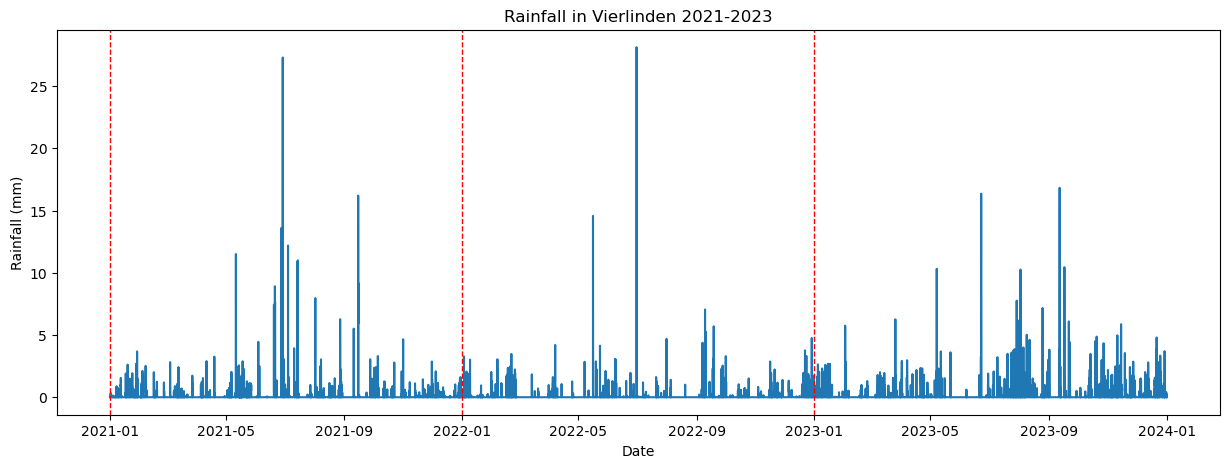

In [9]:
# Plot the rainfall data
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(all_rain_df['Datetime'], all_rain_df['Niederschlag_mm'])
ax.set_title('Rainfall in Vierlinden 2021-2023')
ax.set_xlabel('Date')
ax.set_ylabel('Rainfall (mm)')

# Dashed vertical lines to indicate the start of each year
for year in range(2021, 2024):
    ax.axvline(pd.to_datetime(f'{year}-01-01'), color='r', linestyle='--', linewidth=1)

plt.show()

## Processing RÜB-Werte (Raintank Data)

In [10]:
def create_datetime_column(df : pd.DataFrame, date_format = '%m/%d/%Y %H:%M') -> pd.DataFrame:
    df_t = df.copy()
    
    df_t['Zeit'] = df_t['Zeit'].apply(lambda x: x.split('-')[0])
    df_t['Datetime'] = pd.to_datetime(df_t['Datum'] + ' ' + df_t['Zeit'], format=date_format)
    df_t.drop(columns=['Datum', 'Zeit'], inplace=True)
    df_t.drop_duplicates(subset='Datetime', keep='last', inplace=True)
    
    df_t.set_index('Datetime', inplace=True)
    
    return df_t

entleerung_rueb = create_datetime_column(pd.read_csv(f'{ka_walsum_rueb_21_folder}/Entleerung_RüB.csv'))
fullstand_rrb = create_datetime_column(pd.read_csv(f'{ka_walsum_rueb_21_folder}/Füllstand_RRB.csv'))
fullstand_rueb1 = create_datetime_column(pd.read_csv(f'{ka_walsum_rueb_21_folder}/Füllstand_RüB_1.csv'))
fullstand_rueb2 = create_datetime_column(pd.read_csv(f'{ka_walsum_rueb_21_folder}/Füllstand_RüB_2.csv'))
fullstand_rueb3 = create_datetime_column(pd.read_csv(f'{ka_walsum_rueb_21_folder}/Füllstand_RüB_3.csv'))
regenueberlauf = create_datetime_column(pd.read_csv(f'{ka_walsum_rueb_21_folder}/Regenüberlauf.csv'), date_format='%d.%m.%y %H:%M')

entleerung_names = {
    'Wert': 'PV_15_Entleerung_RUEB_ival',
    'Min': 'PV_15_Entleerung_RUEB_pmin',
    'Max': 'PV_15_Entleerung_RUEB_pmax'
}
fullstand_rrb_names = {
    'Wert': 'PV_15_Fuellstand_RRB_ival',
    'Min': 'PV_15_Fuellstand_RRB_pmin',
    'Max': 'PV_15_Fuellstand_RRB_pmax'
}


print(f'Entleerung RüB: {entleerung_rueb.shape}')
display(entleerung_rueb)

print(f'Füllstand RRB: {fullstand_rrb.shape}')
display(fullstand_rrb)

print(f'Füllstand RüB1: {fullstand_rueb1.shape}')
display(fullstand_rueb1)

print(f'Füllstand RüB2: {fullstand_rueb2.shape}')
display(fullstand_rueb2)

print(f'Füllstand RüB3: {fullstand_rueb3.shape}')
display(fullstand_rueb3)

print(f'Regenüberlauf: {regenueberlauf.shape}')
display(regenueberlauf)


Entleerung RüB: (8759, 3)


,Wert,Min,Max
Datetime,,,
2021-01-01 00:00:00,0.098,0.0,0.2
2021-01-01 01:00:00,0.099,0.0,0.1
2021-01-01 02:00:00,0.096,0.0,0.2
2021-01-01 03:00:00,0.098,0.0,0.2
2021-01-01 04:00:00,0.098,0.0,0.2
...,...,...,...
2021-12-31 19:00:00,0.181,0.1,0.2
2021-12-31 20:00:00,0.179,0.1,0.2
2021-12-31 21:00:00,0.183,0.1,0.2


Füllstand RRB: (8759, 3)


,Wert,Min,Max
Datetime,,,
2021-01-01 00:00:00,1.47,1.47,1.48
2021-01-01 01:00:00,1.47,1.47,1.47
2021-01-01 02:00:00,1.47,1.47,1.47
2021-01-01 03:00:00,1.47,1.47,1.47
2021-01-01 04:00:00,1.47,1.47,1.47
...,...,...,...
2021-12-31 19:00:00,1.06,1.06,1.06
2021-12-31 20:00:00,1.06,1.06,1.06
2021-12-31 21:00:00,1.06,1.06,1.06


Füllstand RüB1: (8759, 3)


,Wert,Min,Max
Datetime,,,
2021-01-01 00:00:00,3.16,3.15,3.16
2021-01-01 01:00:00,3.16,3.15,3.16
2021-01-01 02:00:00,3.16,3.16,3.16
2021-01-01 03:00:00,3.16,3.16,3.16
2021-01-01 04:00:00,3.16,3.15,3.16
...,...,...,...
2021-12-31 19:00:00,1.15,1.15,1.15
2021-12-31 20:00:00,1.15,1.15,1.15
2021-12-31 21:00:00,1.15,1.15,1.15


Füllstand RüB2: (8759, 3)


,Wert,Min,Max
Datetime,,,
2021-01-01 00:00:00,3.08,3.08,3.08
2021-01-01 01:00:00,3.08,3.08,3.08
2021-01-01 02:00:00,3.08,3.08,3.08
2021-01-01 03:00:00,3.08,3.08,3.08
2021-01-01 04:00:00,3.08,3.08,3.08
...,...,...,...
2021-12-31 19:00:00,1.29,1.29,1.29
2021-12-31 20:00:00,1.29,1.29,1.29
2021-12-31 21:00:00,1.29,1.29,1.29


Füllstand RüB3: (8759, 3)


,Wert,Min,Max
Datetime,,,
2021-01-01 00:00:00,2.72,2.71,2.72
2021-01-01 01:00:00,2.72,2.71,2.72
2021-01-01 02:00:00,2.72,2.71,2.72
2021-01-01 03:00:00,2.72,2.71,2.72
2021-01-01 04:00:00,2.72,2.71,2.72
...,...,...,...
2021-12-31 19:00:00,0.62,0.61,0.62
2021-12-31 20:00:00,0.62,0.61,0.62
2021-12-31 21:00:00,0.62,0.61,0.62


Regenüberlauf: (8759, 3)


,Wert,Min,Max
Datetime,,,
2021-01-01 00:00:00,0,0.0,0.0
2021-01-01 01:00:00,0,0.0,0.0
2021-01-01 02:00:00,0,0.0,0.0
2021-01-01 03:00:00,0,0.0,0.0
2021-01-01 04:00:00,0,0.0,0.0
...,...,...,...
2021-12-31 19:00:00,0,0.0,0.0
2021-12-31 20:00:00,0,0.0,0.0
2021-12-31 21:00:00,0,0.0,0.0


In [11]:
rueb_2022_2023 = pd.read_csv(f'{ka_walsum_rueb_22_23_folder}/Walsum_RUEB_Stundenwerte_2022_2023.csv', encoding='latin1', sep=';', decimal = ',', skiprows=1)

rueb_2022_2023['Datetime'] = pd.to_datetime(rueb_2022_2023['Date'] + ' ' + rueb_2022_2023['Time'], format='%d.%m.%Y %H:%M:%S')
rueb_2022_2023.drop(columns=['Date', 'Time'], inplace=True)
rueb_2022_2023.drop_duplicates(subset='Datetime', keep='last', inplace=True)
rueb_2022_2023.set_index('Datetime', inplace=True)

# Remove columns that are not unknown in the data of 2021
rueb_2022_2023 = rueb_2022_2023.drop(columns=['PV_15_Entleerung_RUEB_type', 
                                              'PV_15_Entleerung_RUEB_pmintm', 
                                              'PV_15_Entleerung_RUEB_pmaxtm', 
                                              'PV_15_Entleerung_RUEB_pcount', 
                                              'PV_16_Regenueberlauf_Menge_type', 
                                              'PV_16_Regenueberlauf_Menge_pmintm', 
                                              'PV_16_Regenueberlauf_Menge_pmaxtm', 
                                              'PV_16_Regenueberlauf_Menge_pcount', 
                                              'PV_18_Fuellstand_RUEB_1_type', 
                                              'PV_18_Fuellstand_RUEB_1_pmintm', 
                                              'PV_18_Fuellstand_RUEB_1_pmaxtm', 
                                              'PV_18_Fuellstand_RUEB_1_pcount', 
                                              'PV_19_Fuellstand_RUEB_2_type', 
                                              'PV_19_Fuellstand_RUEB_2_pmintm', 
                                              'PV_19_Fuellstand_RUEB_2_pmaxtm', 
                                              'PV_19_Fuellstand_RUEB_2_pcount', 
                                              'PV_20_Fuellstand_RUEB_3_type', 
                                              'PV_20_Fuellstand_RUEB_3_pmintm', 
                                              'PV_20_Fuellstand_RUEB_3_pmaxtm', 
                                              'PV_20_Fuellstand_RUEB_3_pcount', 
                                              'PV_25_Fuellstand_RRB_type', 
                                              'PV_25_Fuellstand_RRB_pmintm', 
                                              'PV_25_Fuellstand_RRB_pmaxtm', 
                                              'PV_25_Fuellstand_RRB_pcount'
                                              ]
                                     )

rueb_2022_2023

,PV_15_Entleerung_RUEB_ival,PV_15_Entleerung_RUEB_unit,PV_15_Entleerung_RUEB_pmin,PV_15_Entleerung_RUEB_pmax,PV_16_Regenueberlauf_Menge_ival,PV_16_Regenueberlauf_Menge_unit,PV_16_Regenueberlauf_Menge_pmin,PV_16_Regenueberlauf_Menge_pmax,PV_18_Fuellstand_RUEB_1_ival,PV_18_Fuellstand_RUEB_1_unit,...,PV_19_Fuellstand_RUEB_2_pmin,PV_19_Fuellstand_RUEB_2_pmax,PV_20_Fuellstand_RUEB_3_ival,PV_20_Fuellstand_RUEB_3_unit,PV_20_Fuellstand_RUEB_3_pmin,PV_20_Fuellstand_RUEB_3_pmax,PV_25_Fuellstand_RRB_ival,PV_25_Fuellstand_RRB_unit,PV_25_Fuellstand_RRB_pmin,PV_25_Fuellstand_RRB_pmax
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.173,l/s,0.1,0.2,0.0,m³,0.0,0.0,1.15,m,...,1.29,1.29,0.62,m,0.61,0.62,1.06,m,1.06,1.06
2022-01-01 01:00:00,0.176,l/s,0.1,0.2,0.0,m³,0.0,0.0,1.15,m,...,1.29,1.29,0.62,m,0.61,0.62,1.06,m,1.06,1.06
2022-01-01 02:00:00,0.178,l/s,0.1,0.2,0.0,m³,0.0,0.0,1.15,m,...,1.29,1.29,0.62,m,0.61,0.62,1.06,m,1.06,1.06
2022-01-01 03:00:00,0.173,l/s,0.1,0.2,0.0,m³,0.0,0.0,1.15,m,...,1.29,1.29,0.62,m,0.61,0.62,1.06,m,1.06,1.06
2022-01-01 04:00:00,0.177,l/s,0.1,0.2,0.0,m³,0.0,0.0,1.15,m,...,1.29,1.29,0.62,m,0.62,0.62,1.06,m,1.06,1.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 20:00:00,0.118,l/s,0.1,0.2,0.0,m³,0.0,0.0,1.34,m,...,1.78,1.78,0.92,m,0.92,0.93,1.34,m,1.34,1.34
2023-12-31 21:00:00,0.120,l/s,0.1,0.2,0.0,m³,0.0,0.0,1.35,m,...,1.78,1.78,0.92,m,0.92,0.93,1.34,m,1.34,1.34
2023-12-31 22:00:00,0.110,l/s,0.1,0.2,0.0,m³,0.0,0.0,1.35,m,...,1.78,1.78,0.92,m,0.92,0.93,1.34,m,1.34,1.34


In [12]:
rueb_2021 = pd.DataFrame(columns = rueb_2022_2023.columns)
rueb_2021['Datetime'] = pd.to_datetime(entleerung_rueb.index)
rueb_2021.set_index('Datetime', inplace=True)

rueb_2021[['PV_15_Entleerung_RUEB_ival', 'PV_15_Entleerung_RUEB_pmin', 'PV_15_Entleerung_RUEB_pmax']] = entleerung_rueb[['Wert', 'Min', 'Max']]
rueb_2021[['PV_16_Regenueberlauf_Menge_ival', 'PV_16_Regenueberlauf_Menge_pmin', 'PV_16_Regenueberlauf_Menge_pmax']] = regenueberlauf[['Wert', 'Min', 'Max']]
rueb_2021[['PV_18_Fuellstand_RUEB_1_ival', 'PV_18_Fuellstand_RUEB_1_pmin', 'PV_18_Fuellstand_RUEB_1_pmax']] = fullstand_rueb1[['Wert', 'Min', 'Max']]
rueb_2021[['PV_19_Fuellstand_RUEB_2_ival', 'PV_19_Fuellstand_RUEB_2_pmin', 'PV_19_Fuellstand_RUEB_2_pmax']] = fullstand_rueb2[['Wert', 'Min', 'Max']]
rueb_2021[['PV_20_Fuellstand_RUEB_3_ival', 'PV_20_Fuellstand_RUEB_3_pmin', 'PV_20_Fuellstand_RUEB_3_pmax']] = fullstand_rueb3[['Wert', 'Min', 'Max']]
rueb_2021[['PV_25_Fuellstand_RRB_ival', 'PV_25_Fuellstand_RRB_pmin', 'PV_25_Fuellstand_RRB_pmax']] = fullstand_rrb[['Wert', 'Min', 'Max']]

rueb_2021[['PV_15_Entleerung_RUEB_unit']] = rueb_2022_2023.iloc[0]['PV_15_Entleerung_RUEB_unit']
rueb_2021[['PV_16_Regenueberlauf_Menge_unit']] = rueb_2022_2023.iloc[0]['PV_16_Regenueberlauf_Menge_unit']
rueb_2021[['PV_18_Fuellstand_RUEB_1_unit']] = rueb_2022_2023.iloc[0]['PV_18_Fuellstand_RUEB_1_unit']
rueb_2021[['PV_19_Fuellstand_RUEB_2_unit']] = rueb_2022_2023.iloc[0]['PV_19_Fuellstand_RUEB_2_unit']
rueb_2021[['PV_20_Fuellstand_RUEB_3_unit']] = rueb_2022_2023.iloc[0]['PV_20_Fuellstand_RUEB_3_unit']
rueb_2021[['PV_25_Fuellstand_RRB_unit']] = rueb_2022_2023.iloc[0]['PV_25_Fuellstand_RRB_unit']

rueb_2021

,PV_15_Entleerung_RUEB_ival,PV_15_Entleerung_RUEB_unit,PV_15_Entleerung_RUEB_pmin,PV_15_Entleerung_RUEB_pmax,PV_16_Regenueberlauf_Menge_ival,PV_16_Regenueberlauf_Menge_unit,PV_16_Regenueberlauf_Menge_pmin,PV_16_Regenueberlauf_Menge_pmax,PV_18_Fuellstand_RUEB_1_ival,PV_18_Fuellstand_RUEB_1_unit,...,PV_19_Fuellstand_RUEB_2_pmin,PV_19_Fuellstand_RUEB_2_pmax,PV_20_Fuellstand_RUEB_3_ival,PV_20_Fuellstand_RUEB_3_unit,PV_20_Fuellstand_RUEB_3_pmin,PV_20_Fuellstand_RUEB_3_pmax,PV_25_Fuellstand_RRB_ival,PV_25_Fuellstand_RRB_unit,PV_25_Fuellstand_RRB_pmin,PV_25_Fuellstand_RRB_pmax
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.098,l/s,0.0,0.2,0,m³,0.0,0.0,3.16,m,...,3.08,3.08,2.72,m,2.71,2.72,1.47,m,1.47,1.48
2021-01-01 01:00:00,0.099,l/s,0.0,0.1,0,m³,0.0,0.0,3.16,m,...,3.08,3.08,2.72,m,2.71,2.72,1.47,m,1.47,1.47
2021-01-01 02:00:00,0.096,l/s,0.0,0.2,0,m³,0.0,0.0,3.16,m,...,3.08,3.08,2.72,m,2.71,2.72,1.47,m,1.47,1.47
2021-01-01 03:00:00,0.098,l/s,0.0,0.2,0,m³,0.0,0.0,3.16,m,...,3.08,3.08,2.72,m,2.71,2.72,1.47,m,1.47,1.47
2021-01-01 04:00:00,0.098,l/s,0.0,0.2,0,m³,0.0,0.0,3.16,m,...,3.08,3.08,2.72,m,2.71,2.72,1.47,m,1.47,1.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,0.181,l/s,0.1,0.2,0,m³,0.0,0.0,1.15,m,...,1.29,1.29,0.62,m,0.61,0.62,1.06,m,1.06,1.06
2021-12-31 20:00:00,0.179,l/s,0.1,0.2,0,m³,0.0,0.0,1.15,m,...,1.29,1.29,0.62,m,0.61,0.62,1.06,m,1.06,1.06
2021-12-31 21:00:00,0.183,l/s,0.1,0.2,0,m³,0.0,0.0,1.15,m,...,1.29,1.29,0.62,m,0.61,0.62,1.06,m,1.06,1.06


In [13]:
rueb_df = pd.concat([rueb_2021, rueb_2022_2023])
rueb_df.sort_index(inplace=True)

numeric_columns = rueb_df.columns.difference(['PV_15_Entleerung_RUEB_unit', 
                                              'PV_16_Regenueberlauf_Menge_unit', 
                                              'PV_18_Fuellstand_RUEB_1_unit', 
                                              'PV_19_Fuellstand_RUEB_2_unit', 
                                              'PV_20_Fuellstand_RUEB_3_unit', 
                                              'PV_25_Fuellstand_RRB_unit'
                                             ], sort = False)

for column in numeric_columns:
    rueb_df[column] = rueb_df[column].astype(str).str.replace(',', '.')
    rueb_df[column] = pd.to_numeric(rueb_df[column], errors='coerce')

rueb_df.to_csv(regenbecken_filename)
print(f'Saved regenbecken data to {regenbecken_filename}')

rueb_df

Saved regenbecken data to regenbecken_vierlinden.csv


,PV_15_Entleerung_RUEB_ival,PV_15_Entleerung_RUEB_unit,PV_15_Entleerung_RUEB_pmin,PV_15_Entleerung_RUEB_pmax,PV_16_Regenueberlauf_Menge_ival,PV_16_Regenueberlauf_Menge_unit,PV_16_Regenueberlauf_Menge_pmin,PV_16_Regenueberlauf_Menge_pmax,PV_18_Fuellstand_RUEB_1_ival,PV_18_Fuellstand_RUEB_1_unit,...,PV_19_Fuellstand_RUEB_2_pmin,PV_19_Fuellstand_RUEB_2_pmax,PV_20_Fuellstand_RUEB_3_ival,PV_20_Fuellstand_RUEB_3_unit,PV_20_Fuellstand_RUEB_3_pmin,PV_20_Fuellstand_RUEB_3_pmax,PV_25_Fuellstand_RRB_ival,PV_25_Fuellstand_RRB_unit,PV_25_Fuellstand_RRB_pmin,PV_25_Fuellstand_RRB_pmax
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,0.098,l/s,0.0,0.2,0.0,m³,0.0,0.0,3.16,m,...,3.08,3.08,2.72,m,2.71,2.72,1.47,m,1.47,1.48
2021-01-01 01:00:00,0.099,l/s,0.0,0.1,0.0,m³,0.0,0.0,3.16,m,...,3.08,3.08,2.72,m,2.71,2.72,1.47,m,1.47,1.47
2021-01-01 02:00:00,0.096,l/s,0.0,0.2,0.0,m³,0.0,0.0,3.16,m,...,3.08,3.08,2.72,m,2.71,2.72,1.47,m,1.47,1.47
2021-01-01 03:00:00,0.098,l/s,0.0,0.2,0.0,m³,0.0,0.0,3.16,m,...,3.08,3.08,2.72,m,2.71,2.72,1.47,m,1.47,1.47
2021-01-01 04:00:00,0.098,l/s,0.0,0.2,0.0,m³,0.0,0.0,3.16,m,...,3.08,3.08,2.72,m,2.71,2.72,1.47,m,1.47,1.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 20:00:00,0.118,l/s,0.1,0.2,0.0,m³,0.0,0.0,1.34,m,...,1.78,1.78,0.92,m,0.92,0.93,1.34,m,1.34,1.34
2023-12-31 21:00:00,0.120,l/s,0.1,0.2,0.0,m³,0.0,0.0,1.35,m,...,1.78,1.78,0.92,m,0.92,0.93,1.34,m,1.34,1.34
2023-12-31 22:00:00,0.110,l/s,0.1,0.2,0.0,m³,0.0,0.0,1.35,m,...,1.78,1.78,0.92,m,0.92,0.93,1.34,m,1.34,1.34


## Merging all the Data together

In [14]:
pumpbauwerk_df = pd.read_csv(pumpbauwerk_filename)
rain_df = pd.read_csv(rainfall_filename)
rueb_df = pd.read_csv(regenbecken_filename)

pumpbauwerk_df['Datetime'] = pd.to_datetime(pumpbauwerk_df['Datetime'])
rain_df['Datetime'] = pd.to_datetime(rain_df['Datetime'])
rueb_df['Datetime'] = pd.to_datetime(rueb_df['Datetime'])

rueb_cols = ['Datetime',
             'PV_15_Entleerung_RUEB_ival',
             'PV_16_Regenueberlauf_Menge_ival',
             'PV_18_Fuellstand_RUEB_1_ival',
             'PV_19_Fuellstand_RUEB_2_ival',
             'PV_20_Fuellstand_RUEB_3_ival',
             'PV_25_Fuellstand_RRB_ival']

t = pd.merge(pumpbauwerk_df, rain_df, on='Datetime', how='outer')
final_df = pd.merge(t, rueb_df[rueb_cols], on='Datetime', how='outer')

for column in final_df:
    if column != 'Datetime':
        # Round to 4 decimal places to remove floating point errors
        final_df[column] = final_df[column].round(4)

final_df.to_csv(final_data_filename, index=False)
print(f'Saved final data to {final_data_filename}')

final_df

Saved final data to vierlinden_21_22_23_all.csv


,Datetime,Herzog_Schieber_Position_pval,Herzog_Oberwasser_pval,Herzog_Unterwasser_pval,Herzog_Durchflußmenge_pval,Herzog_Berechnete_Durchflussmenge_pval,FLP_Hohenstand_Pumpensumpf_pval,FLP_P3_pval,FLP_P4_pval,FLP_P5_pval,...,Verlindenhof_Pumpe_1_pval,Verlindenhof_Pumpe_2_pval,Verlindenhof_Pumpe_3_pval,Niederschlag_mm,PV_15_Entleerung_RUEB_ival,PV_16_Regenueberlauf_Menge_ival,PV_18_Fuellstand_RUEB_1_ival,PV_19_Fuellstand_RUEB_2_ival,PV_20_Fuellstand_RUEB_3_ival,PV_25_Fuellstand_RRB_ival
0,2021-01-01 00:00:00,100.0,8.0761,5.8152,7.6009,7.5300,NaN,NaN,NaN,NaN,...,0.0000,0.0,1.0,0.00,0.098,0.0,3.16,3.08,2.72,1.47
1,2021-01-01 01:00:00,100.0,8.0841,5.3923,7.1753,8.0380,NaN,NaN,NaN,NaN,...,0.0000,0.0,1.0,0.00,0.099,0.0,3.16,3.08,2.72,1.47
2,2021-01-01 02:00:00,100.0,7.9639,5.1718,6.4808,7.7368,NaN,NaN,NaN,NaN,...,0.0000,0.0,1.0,0.00,0.096,0.0,3.16,3.08,2.72,1.47
3,2021-01-01 03:00:00,100.0,7.6138,5.0000,5.2214,6.1928,NaN,NaN,NaN,NaN,...,0.0000,0.0,1.0,0.00,0.098,0.0,3.16,3.08,2.72,1.47
4,2021-01-01 04:00:00,100.0,6.9667,4.5230,3.5886,4.3735,NaN,NaN,NaN,NaN,...,3.5338,0.0,1.0,0.00,0.098,0.0,3.16,3.08,2.72,1.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26276,2023-12-31 20:00:00,100.0,9.6343,6.0298,0.0000,12.6065,91.5546,0.0,0.0,-1.0,...,0.0000,0.0,1.0,0.00,0.118,0.0,1.34,1.78,0.92,1.34
26277,2023-12-31 21:00:00,100.0,9.0974,5.9716,0.0000,10.9807,89.5880,0.0,0.0,-1.0,...,0.0000,0.0,1.0,0.00,0.120,0.0,1.35,1.78,0.92,1.34
26278,2023-12-31 22:00:00,100.0,8.7244,5.6111,0.0000,10.1204,90.6291,0.0,0.0,-1.0,...,0.0000,0.0,1.0,0.26,0.110,0.0,1.35,1.78,0.92,1.34
26279,2023-12-31 23:00:00,100.0,8.5567,5.2766,0.0000,10.0989,89.4323,0.0,0.0,-1.0,...,0.0000,0.0,1.0,0.07,0.112,0.0,1.36,1.78,0.92,1.34


In [15]:
print(final_df.dtypes)

Datetime                                   datetime64[ns]
Herzog_Schieber_Position_pval                     float64
Herzog_Oberwasser_pval                            float64
Herzog_Unterwasser_pval                           float64
Herzog_Durchflußmenge_pval                        float64
Herzog_Berechnete_Durchflussmenge_pval            float64
FLP_Hohenstand_Pumpensumpf_pval                   float64
FLP_P3_pval                                       float64
FLP_P4_pval                                       float64
FLP_P5_pval                                       float64
FLP_Durchfluss_SWP1_und_SWP2_pval                 float64
FLP_Hohenstand_Becken1_pval                       float64
FLP_Hohenstand_Becken3_pval                       float64
FLP_Hohenstand_Beckne2_pval                       float64
Kaiserstr_Füllstand_SWS_pval                      float64
Kaiserstr_Füllstand_RWS_pval                      float64
Kaiserstr_P1_pval                                 float64
Kaiserstr_P2_p